In [1]:
import numpy as np
import os
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
import random

In [2]:
ds_path = "datasets/Intel Image Classification/"
train_path = os.path.join(ds_path, "seg_train")
test_path = os.path.join(ds_path, "seg_test")

classes = os.listdir(train_path)
classes 

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [3]:
BATCHSIZE = 32
N_WORKERS = 2

In [4]:
test_transform = transforms.Compose([
    transforms.Resize((150, 150)),  
    transforms.ToTensor(),          
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

full_train_ds = datasets.ImageFolder(root=train_path, transform=test_transform)
test_ds = datasets.ImageFolder(root=test_path, transform=test_transform)

train_ds, val_ds = random_split(full_train_ds, [0.8, 0.2])

In [5]:
test_loader = DataLoader(test_ds, batch_size=BATCHSIZE, shuffle=False)
train_loader = DataLoader(train_ds, batch_size=BATCHSIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCHSIZE, shuffle=False)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
def visualize_scores(metrics):
    train_losses, train_accs, train_f1s, val_losses, val_accs, val_f1s = metrics
    epochs = range(1, len(train_losses) + 1)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].plot(epochs, train_losses, label="Train Loss")
    axes[0].plot(epochs, val_losses, label="Val Loss")
    axes[0].set_title("Loss")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].grid(visible=True)
    axes[0].legend()

    axes[1].plot(epochs, train_accs, label="Train Accuracy")
    axes[1].plot(epochs, val_accs, label="Val Accuracy")
    axes[1].set_title("Accuracy")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy")
    axes[1].grid(visible=True)
    axes[1].legend()

    axes[2].plot(epochs, train_f1s, label="Train F1-score")
    axes[2].plot(epochs, val_f1s, label="Val F1-score")
    axes[2].set_title("F1-score")
    axes[2].set_xlabel("Epochs")
    axes[2].set_ylabel("F1-score")
    axes[2].grid(visible=True)
    axes[2].legend()

    plt.tight_layout()
    plt.show()


In [8]:
def conf_matrices(y_true_train, y_pred_train, y_true_val, y_pred_val, class_names):
    cm_train = confusion_matrix(y_true_train, y_pred_train)
    cm_val = confusion_matrix(y_true_val, y_pred_val)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, ax=axes[0])
    axes[0].set_title("Train Confusion Matrix")
    axes[0].set_xlabel("Predicted Labels")
    axes[0].set_ylabel("True Labels")

    sns.heatmap(cm_val, annot=True, fmt="d", cmap="Oranges", xticklabels=class_names, yticklabels=class_names, ax=axes[1])
    axes[1].set_title("Validation Confusion Matrix")
    axes[1].set_xlabel("Predicted Labels")
    axes[1].set_ylabel("True Labels")

    plt.tight_layout()
    plt.show()


In [9]:
def get_predictions(model, dataloader):

    model.eval()  
    y_true = []
    y_pred = []

    with torch.no_grad():  
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)  
            outputs = model(images)  
            _, predicted = torch.max(outputs, 1)  
            
            y_true.extend(labels.cpu().numpy())  
            y_pred.extend(predicted.cpu().numpy())  

    return np.array(y_true), np.array(y_pred)

In [10]:
def visualize(model, metrics):
        visualize_scores(metrics)
        val_true, val_pred = get_predictions(model, val_loader)
        train_true, train_pred = get_predictions(model, train_loader)
        conf_matrices(train_true, train_pred, val_true, val_pred, classes)

In [11]:
class CNN_3blocks_dr04(nn.Module):
    def __init__(self, n_classes=6):
        super(CNN_3blocks_dr04, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(128)
        self.bn5 = nn.BatchNorm2d(128)
        self.bn6 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.4)

        
        self.fc1 = nn.Linear(256 * 18 * 18, 512)  
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, n_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool(x)

        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  

        return x


In [13]:
chekpoint = torch.load('models/v4_3_final.pth', weights_only=False)

In [14]:
model = CNN_3blocks_dr04(6).to(device)
model.load_state_dict(chekpoint['model_state_dict'])

<All keys matched successfully>

In [15]:
metrics = chekpoint['metrics']

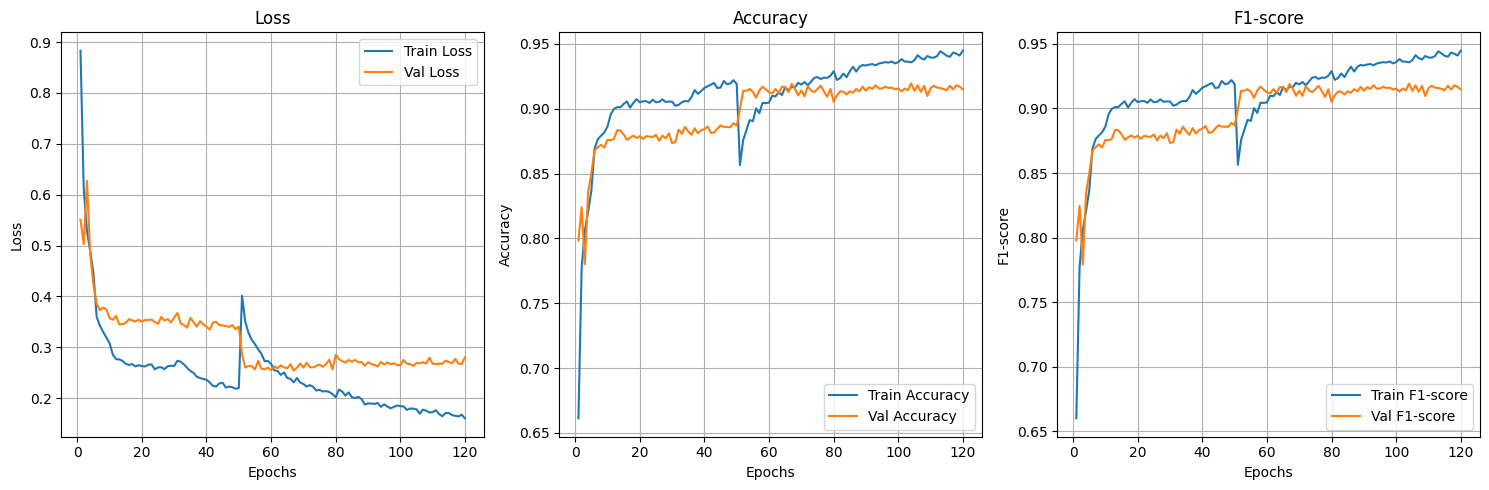

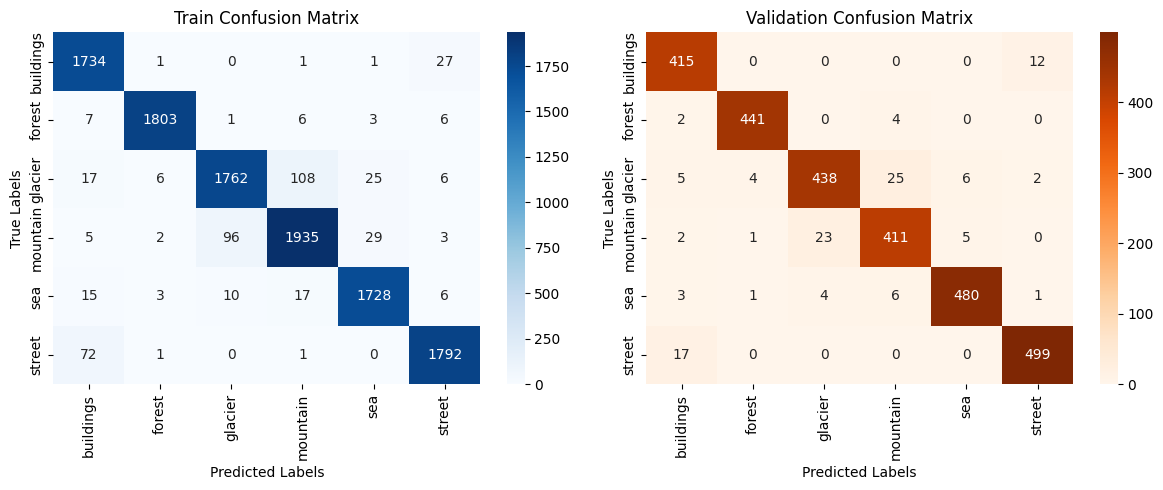

In [16]:
visualize(model, metrics)

In [31]:
y_true, y_pred = get_predictions(model, test_loader)
f1_test = f1_score(y_true, y_pred, average="weighted")
acc_test = accuracy_score(y_true, y_pred)
print(f"Test Metrics\n\naccuracy: {acc_test:.2f} | f1 score: {f1_test:.2f}")

Test Metrics

accuracy: 0.90 | f1 score: 0.90


In [27]:
f1_test

0.8971373914475765

In [28]:
acc_test

0.8973333333333333

In [29]:
chekpoint = torch.load('models/v4_3dr.pth', weights_only=False)
model2 = CNN_3blocks_dr04(6).to(device)
model2.load_state_dict(chekpoint['model_state_dict'])

<All keys matched successfully>

In [30]:
y_true, y_pred = get_predictions(model2, test_loader)
f1_test = f1_score(y_true, y_pred, average="weighted")
acc_test = accuracy_score(y_true, y_pred)
print(f"Test Metrics\n\naccuracy: {acc_test:.2f} | f1 score: {f1_test:.2f}")

Test Metrics

accuracy: 0.89 | f1 score: 0.89


In [43]:
def show_wrong(dataset, y_true, y_pred, n=10, class_names=None):
    wrong_indices = [i for i, (t, p) in enumerate(zip(y_true, y_pred)) if t != p]

    selected_indices = random.sample(wrong_indices, n)
    samples = [dataset[i] for i in selected_indices]
    
    images, true_labels = zip(*samples)
    pred_labels = [y_pred[i] for i in selected_indices]

    images = torch.stack(images).permute(0, 2, 3, 1).numpy()
    images = (images * 0.5 + 0.5).clip(0, 1) 

    plt.figure(figsize=(15, 6))
    for i in range(len(images)):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i])
        true_class = class_names[true_labels[i]] if class_names else true_labels[i]
        pred_class = class_names[pred_labels[i]] if class_names else pred_labels[i]
        plt.title(f"True:{true_class}\nPred:{pred_class}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()



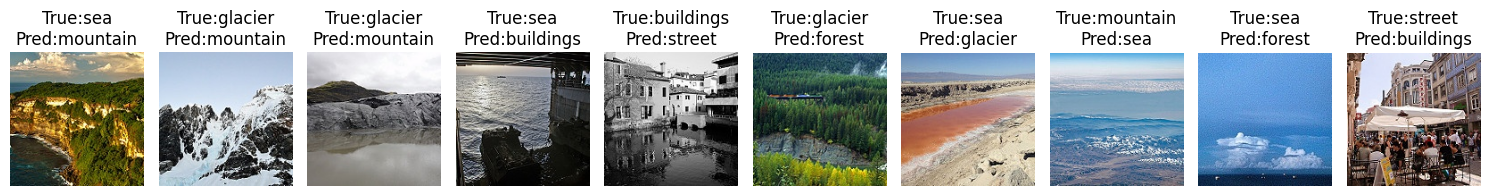

In [44]:
show_wrong(test_ds,y_true, y_pred, 10, test_ds.classes )

In [33]:
def show_unlabeled(dataset, model, n=5):
    model.eval()
    indices = random.sample(range(len(dataset)), n)

    images = []
    labels = []
    preds = []

    for idx in indices:
        img, label = dataset[idx]
        images.append(img)
        labels.append(label)

        with torch.no_grad():
            input_img = img.unsqueeze(0).to(device)
            pred = model(input_img).argmax(dim=1).item()
            preds.append(pred)

    plt.figure(figsize=(15, 3 * ((n + 4) // 5)))
    for i, img in enumerate(images):
        img_vis = img.permute(1, 2, 0).numpy()
        img_vis = img_vis * 0.5 + 0.5  
        plt.subplot((n + 4) // 5, 5, i + 1)
        plt.imshow(img_vis)
        plt.title(f"Image {i + 1}")
        plt.axis("off")
    plt.suptitle("Try to Guess the Class!")
    plt.tight_layout()
    plt.show()

    return images, labels, preds

def show_labeled(images, labels, preds, class_names):
    n = len(images)
    plt.figure(figsize=(15, 3 * ((n + 4) // 5)))

    for i, img in enumerate(images):
        img_vis = img.permute(1, 2, 0).numpy()
        img_vis = img_vis * 0.5 + 0.5  
        plt.subplot((n + 4) // 5, 5, i + 1)
        plt.imshow(img_vis)
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
        plt.axis("off")
    plt.suptitle("Correct Answers")
    plt.tight_layout()
    plt.show()


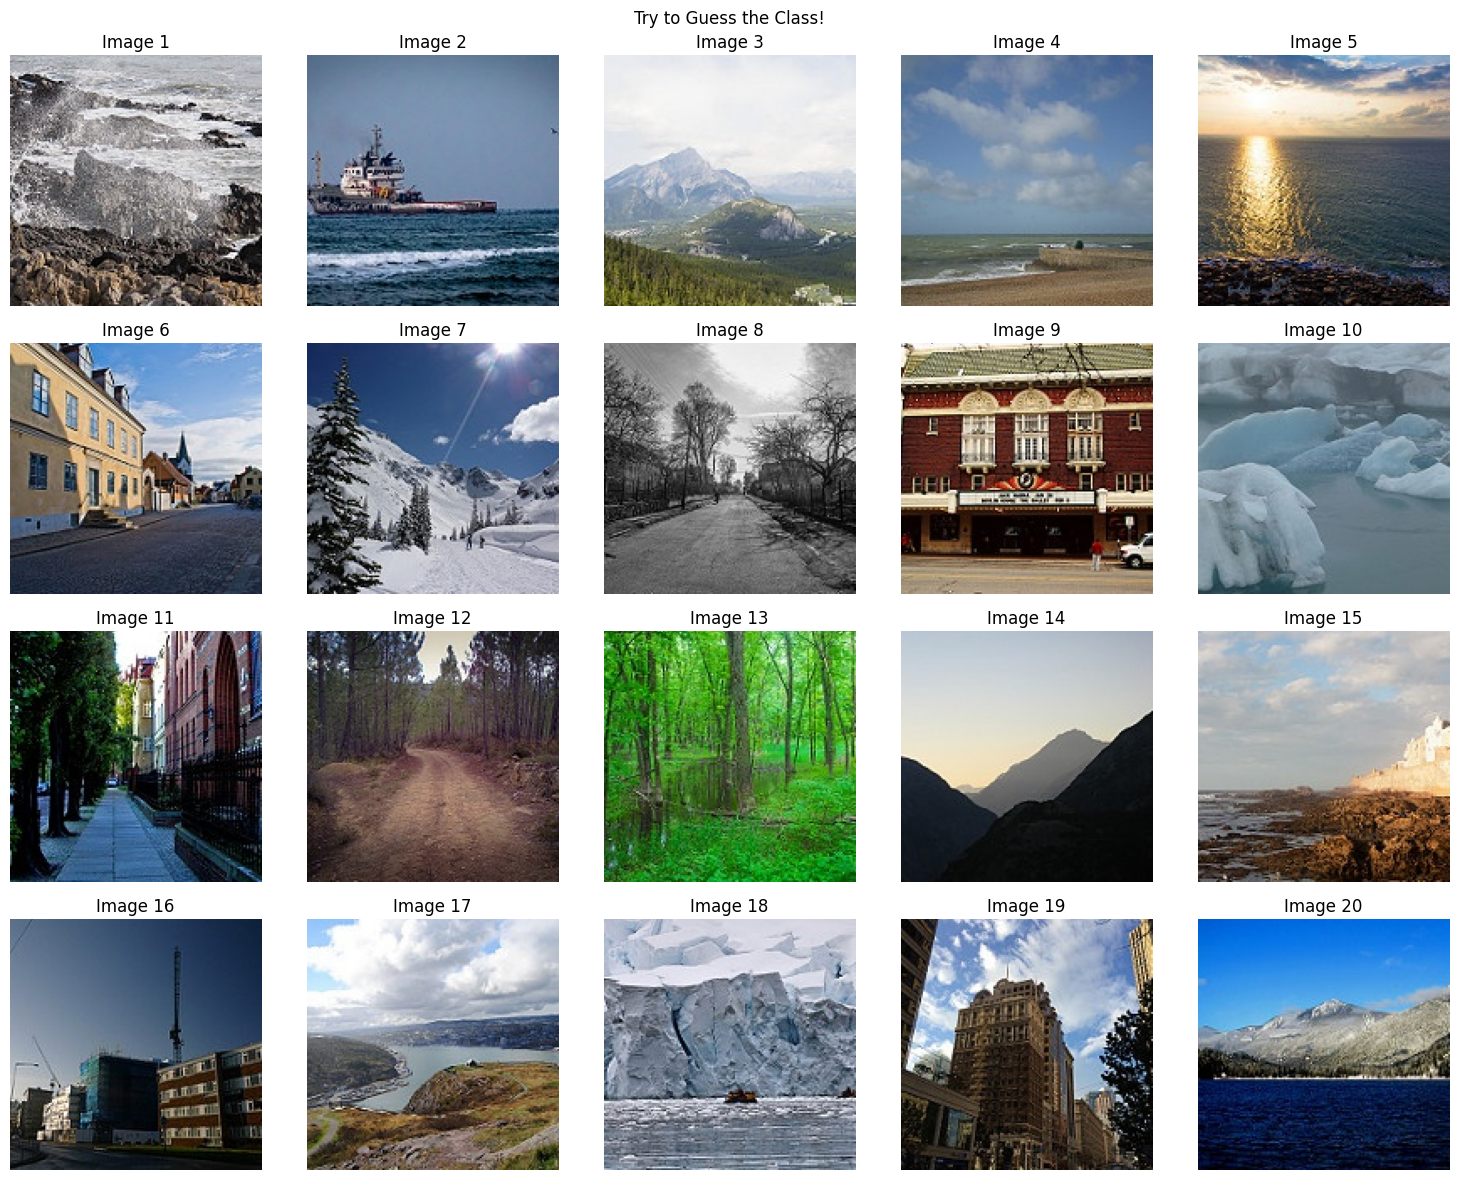

In [35]:
images, labels, preds = show_unlabeled(val_ds, model, 20)

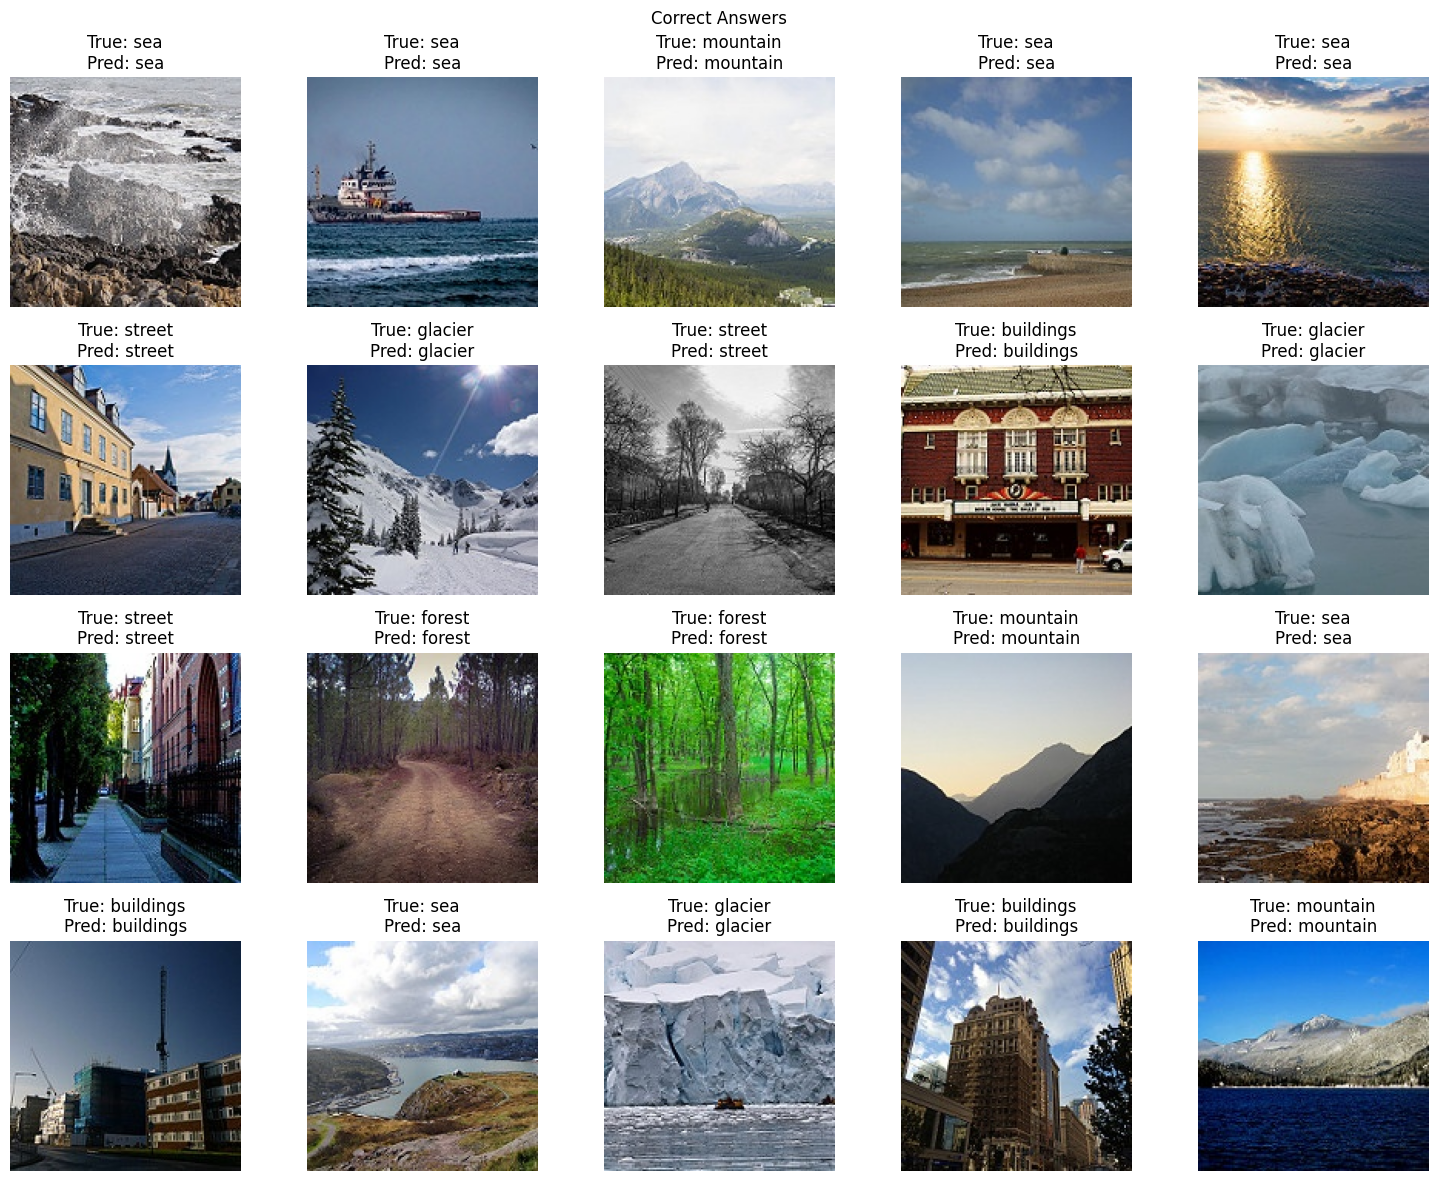

In [36]:
show_labeled(images, labels, preds, test_ds.classes)